# GenAI with Python: Cybersecurity Agent

###### [Read the Article on TDS]()

### Anomaly Detection

In [18]:
import numpy as np
import pandas as pd

## create dataset
n_obs, n_features = 1000, 5
n_anomalies = 10
obs = np.random.normal(loc=0, scale=1, size=(n_obs-n_anomalies, n_features))

## generate anomalies
anomalies = np.random.normal(loc=0, scale=5, size=(n_anomalies, n_features))
dtf = pd.DataFrame(data=np.vstack((obs, anomalies)), columns=["x"+str(i+1) for i in range(n_features)])

## shuffle
dtf = dtf.sample(frac=1).reset_index(drop=True).round(decimals=2)
dtf.head(3)

,x1,x2,x3,x4,x5
0,-1.54,-0.09,1.10,1.05,0.29
1,2.01,0.14,-0.36,0.73,-0.58
2,0.49,0.52,0.55,-0.28,-0.51


In [19]:
## detect anomalies
from sklearn.ensemble import IsolationForest

model = IsolationForest()
preds = model.fit_predict(dtf)

np.count_nonzero(preds==-1)

90

In [20]:
## make it 2D
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
dtf_pca = pd.DataFrame(data=pca.fit_transform(dtf), columns=['p1','p2'])
dtf_pca.head()

,p1,p2
0,-0.982378,-0.108311
1,2.153063,0.319644
2,0.512413,-0.585631
3,1.908247,2.265667
4,1.214885,1.504426


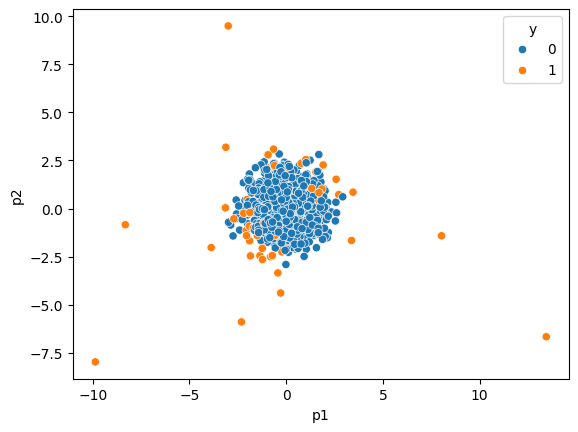

In [21]:
## plot in 2D
import matplotlib.pyplot as plt
import seaborn as sns

dtf_pca['y'] = np.where(preds==-1,1,0)
sns.scatterplot(data=dtf_pca, x='p1', y='p2', hue="y")
plt.show()

### Agent

In [5]:
#pip install ollama==0.5.1
import ollama
llm = "qwen2.5"

stream = ollama.generate(model=llm, prompt='''who are you?''', stream=True)
for chunk in stream:
    print(chunk['response'], end='', flush=True)

I am Qwen, an artificial intelligence model designed and developed by Alibaba Cloud. I am here to assist you with your questions and tasks to the best of my abilities. How may I assist you today?

In [22]:
def detect_anomalies():
    preds = IsolationForest().fit_predict(dtf) #<--path
    dtf_pca = pd.DataFrame(data=pca.fit_transform(dtf), columns=['p1','p2'])
    dtf_pca['y'] = np.where(preds==-1,1,0)
    sns.scatterplot(x='p1', y='p2', data=dtf_pca, hue="y")
    plt.show()
    anomalies = dtf[np.where(preds==-1,1,0) == 1]
    anomalies.to_csv("anomalies.csv", index=False)
    return f"Detected {len(anomalies)} Anomalies" 

tool_detect_anomalies = {'type':'function', 'function':{
  'name': 'detect_anomalies',
  'description': 'Detect Anomalies in the Logs',
  'parameters': {'type':'object', 'required':[], 'properties':{} }}}

In [23]:
def remove_false(query):
    anomalies = pd.read_csv("anomalies.csv")
    real_anomalies = anomalies.query(query)
    real_anomalies.to_csv("anomalies.csv", index=False)
    str_anomalies = "\n".join([str(row) for row in real_anomalies.to_dict(orient='records')])
    return f"Detected {len(real_anomalies)} REAL Anomalies:\n{str_anomalies}"

tool_remove_false = {'type':'function', 'function':{
  'name': 'remove_false',
  'description': 'Remove false positive, keeping only real Anomalies',
  'parameters': {'type':'object', 'required':[], 'properties':{
      "query": {'type':'str', 'description':'query to filter the dataframe, like "x1>10"'}
  } }}}

In [24]:
dic_tools = {'detect_anomalies':detect_anomalies, 'remove_false':remove_false}

In [25]:
def use_tool(agent_res:dict, dic_tools:dict) -> dict:
    ## use tool
    if agent_res["message"].tool_calls is not None:
        for tool in agent_res["message"].tool_calls:
            t_name, t_inputs = tool["function"]["name"], tool["function"]["arguments"]
            if f := dic_tools.get(t_name):
                ### calling tool
                print('🔧 >', f"\x1b[1;31m{t_name} -> Inputs: {t_inputs}\x1b[0m")
                ### tool output
                t_output = f(**tool["function"]["arguments"])
                print(t_output)
                ### final res
                res = t_output
            else:
                print('🤬 >', f"\x1b[1;31m{t_name} -> NotFound\x1b[0m")      
    ## don't use tool
    else:
        res = agent_res["message"].content
        t_name, t_inputs = '', ''
    return {'res':res, 'tool_used':t_name, 'inputs_used':t_inputs}

🙂 > hi


👽 > Hello! How can I assist you today? Are you ready to check the logs for any anomalies, or do you need more information on how this process works?


🙂 > some competitors reported an attack. check if we are good


🔧 > detect_anomalies -> Inputs: {}


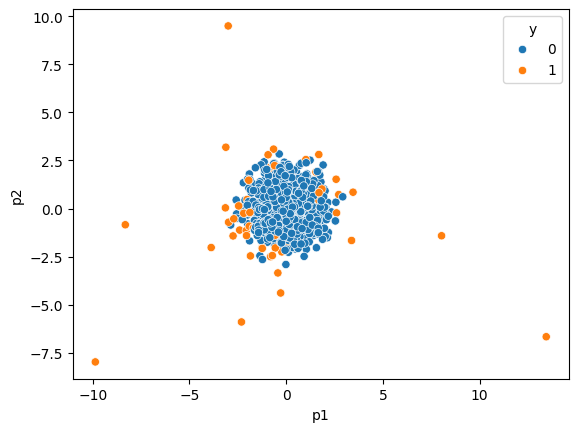

Detected 73 Anomalies
👽 > Based on your cybersecurity checks and analysis, 73 anomalies have been detected. According to our internal policy, any anomaly in column 'x1' above five is considered a real threat and needs to be reported to the Cyber Crime team.


🙂 > before reporting, make sure there are no false positive


🔧 > detect_anomalies -> Inputs: {}


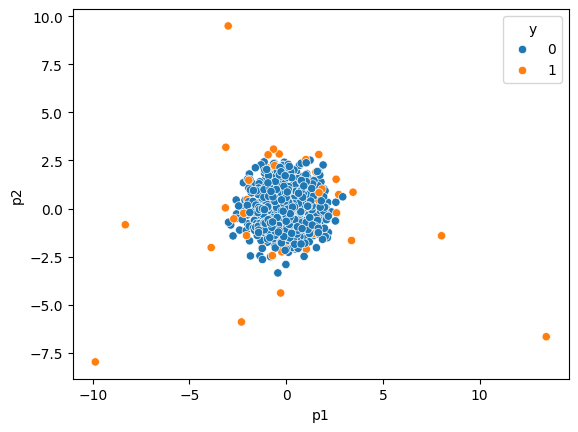

Detected 62 Anomalies
🔧 > remove_false -> Inputs: {'query': 'x1 > 5'}
Detected 2 REAL Anomalies:
{'x1': 11.19, 'x2': -4.65, 'x3': 0.93, 'x4': -0.2, 'x5': -10.56}
{'x1': 6.58, 'x2': 3.11, 'x3': 0.0, 'x4': 2.33, 'x5': -4.4}
👽 > Before reporting the findings to the Cyber Crime team, ensure that there are no false positives by using the tool 'remove_false'. Since your internal policy states that a column 'x1' above five indicates a real anomaly, you have already identified and removed any false positives according to this policy. Therefore, you can confidently summarize the results as:

Detected 2 REAL Anomalies:
{'x1': 11.19, 'x2': -4.65, 'x3': 0.93, 'x4': -0.2, 'x5': -10.56}
{'x1': 6.58, 'x2': 3.11, 'x3': 0.0, 'x4': 2.33, 'x5': -4.4}

You can now proceed to report these findings to the Cyber Crime team with confidence, as they are in line with your internal policy criteria for real anomalies.


🙂 > report it then. write an email explaining the situation


👽 > Sure, I'll prepare a draft email that explains the situation based on the detected and removed anomalies. Here’s a sample email:

---

**Subject:** Report of Detected Anomalies

Dear Cyber Crime Team,

I am writing to report the recent analysis performed on our logs. According to our internal policy, we have identified 2 real anomalies as per our detection tool.

### Real Anomalies Identified:
1. **Anomaly ID: #001**
   - Values: {'x1': 11.19, 'x2': -4.65, 'x3': 0.93, 'x4': -0.2, 'x5': -10.56}
   
2. **Anomaly ID: #002**
   - Values: {'x1': 6.58, 'x2': 3.11, 'x3': 0.0, 'x4': 2.33, 'x5': -4.4}

These anomalies were identified and confirmed as real according to our internal policy criteria (column 'x1' value > 5).

### Summary

- **Anomalies Detected:** 73
- **Real Anomalies Identified:** 2

Please review the findings and take necessary action in accordance with our security protocols.

Best regards,
[Your Name]
Cybersecurity Officer

---

Feel free to send this email as it includes 

🙂 > quit


In [26]:
prompt = '''
You are a cybersecurity officer. You can use your tools to detect and report anomalies.
First you check the Logs to detect anomalies. 

Then, you remove the false positives with the tool 'remove_false'.
When you check the false positive, you must remember that according to our internal policy,
it is a real anomaly only if the column 'x1' is above FIVE.
So if you use this tool, ALWAYS mention that it is 'according to  our internal policy'.

Finally, you report the findings to the Cyber Crime team.
'''

messages = [{"role":"system", "content":prompt}]

while True:
    ## User
    q = input('🙂 >')
    if q == "quit":
        break
    messages.append( {"role":"user", "content":q} )
    
    ## Model
    agent_res = ollama.chat(model=llm, messages=messages, tools=[tool_detect_anomalies, tool_remove_false])
    dic_res = use_tool(agent_res, dic_tools)
    res, tool_used, inputs_used = dic_res["res"], dic_res["tool_used"], dic_res["inputs_used"]  
    
    ## Process Tool Output
    if tool_used != '':
        p = f'''CONTEXT: {prompt}\n\n QUESTION: {q}.\n\n SUMMARIZE THIS ANSWER: {res}'''
        res = ollama.generate(model=llm, prompt=p)["response"]

    ## Response
    print("👽 >", f"\x1b[1;30m{res}\x1b[0m")
    messages.append( {"role":"assistant", "content":res} )